In [2]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax
import numpy as np

In [6]:
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, StackedLegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.problems import WaveEquation2D

subdomain_xs=[np.linspace(0,1,3), np.linspace(0,1,3)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 1.2),
        unnorm=(0.,5.),
    ),
    network=StackedChebyshevKAN,
    network_init_kwargs = dict(
        dims=[2, 1],
        degrees=[16]
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=30000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

# run = FBPINNTrainer(c)
# all_params = run.train()

In [7]:
# all_params_ = all_params
# all_params = all_params_[0]

In [8]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp

def load_model(path):
    # 1) Un-pickle to get your pytree of numpy ndarrays (and other objects)
    with open(path, "rb") as f:
        model = pickle.load(f)

    # 2) Convert any numpy arrays back into JAX arrays
    model = jax.tree_map(
        lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x,
        model
    )
    return model

# usage
n, all_params, all_opt_states, active, u_test_losses = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/model_00030000.jax")

In [9]:
# l1 = all_params['trainable']['network']['subdomain']['coeffs_list'][0][4]
# l2 = all_params['trainable']['network']['subdomain']['coeffs_list'][1][4]
# l1.shape, l2.shape

In [10]:
# points = RectangularDomainND.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)
# points.shape

In [11]:
import matplotlib.pyplot as plt

def plot_sch(data_list, noshow=False):
    # Example: generating some data of shape (2, 200, 200) (real and imaginary)
    data = data_list
    n_fields, Ny, Nx = data.shape
    y = np.arange(Ny)
    x = np.arange(Nx)
    X, Y = np.meshgrid(x, y)
    
    titles = ['wave']  # extend or truncate as needed

    # create one tall figure with n_fields rows
    fig = plt.figure(figsize=(8, 4 * n_fields))
    for i in range(n_fields):
        ax = fig.add_subplot(n_fields, 1, i+1, projection='3d')
        # 100 levels; use ax.contour3D (alias for Axes3D.contour)
        cont = ax.contour3D(X, Y, data[i], 200, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.set_title(titles[i] if i < len(titles) else f'field {i}')
        
    if not noshow:
        plt.tight_layout()
        plt.show()

In [12]:
decomp = RectangularDecompositionND
from jax import vmap
import fbpinns.windows as windows

def norm_fn(params, x):
    xmin, xmax = params["static"]["decomposition"]["subdomain"]["params"][:2]
    mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
    return (x-mu)/sd

def unnorm_fn(params, u):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    mu, sd = params[5]
    return (u-mu)/sd

def net(params, x, model_i=4):
    layer1 = params['trainable']['network']['subdomain']['coeffs_list'][0][model_i]
    layer2 = params['trainable']['network']['subdomain']['coeffs_list'][1][model_i]

    o = x
    o = ChebyshevKAN.forward(coeffs=layer1, kind=2, x=o)
    o = ChebyshevKAN.forward(coeffs=layer2, kind=2, x=o)
    return o

def window(params, x):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    a = params[4]*windows.cosine(*params[:2], x)+(1-params[4])
    return a

def foo(params, x, norm, network_fn, unnorm, window_fn):
    normed = norm(params, x)
    uraw = network_fn(params, normed)
    unnormed = unnorm(params, uraw)
    w = window_fn(params, x)
    return unnormed*w, w, uraw


In [13]:
# for i in range(9):
#     plot_sch(points_split_by_region[:, i, :].reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))

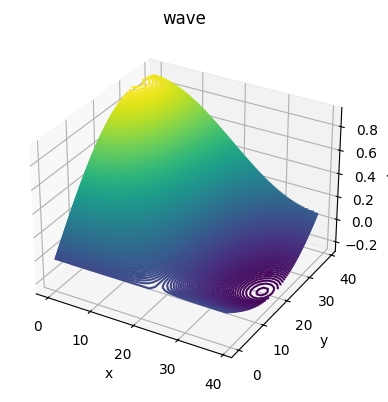

In [14]:
with open('/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave/CKAN_8/test_exact.npy', 'rb') as f:
    exact_wave = np.load(f).reshape(200, 200, -1)
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

In [15]:
from fbpinns.trainers import get_inputs, _common_train_initialisation
from jax import random

(optimiser, all_opt_states, optimiser_fn, loss_fn, key,
        constraints_global, x_batch_global, constraint_offsets_global, constraint_fs_global, jmapss,
        x_batch_test, u_exact) = _common_train_initialisation(c, random.PRNGKey(c.seed), all_params, problem=WaveEquation2D, domain=RectangularDomainND)

active_test_ = jnp.ones(all_params["static"]["decomposition"]["m"], dtype=int)

takes_, all_ims_, (_, _, _, cut_all_, _)  = get_inputs(x_batch_test, active_test_, all_params, RectangularDecompositionND)

test_inputs = (takes_, all_ims_, cut_all_)

takes = takes_
m_take, n_take, p_take, np_take, npou = takes

[INFO] 2025-05-19 15:47:50 - Total number of trainable parameters:
[INFO] 2025-05-19 15:47:50 - 	attention: 40,000
[INFO] 2025-05-19 15:47:50 - 	network: 648
[INFO] 2025-05-19 15:47:50 - 	problem: 40,001
[INFO] 2025-05-19 15:47:50 - Total number of constraints: 1
[INFO] 2025-05-19 15:47:51 - Computing exact solution..
[INFO] 2025-05-19 15:47:51 - Computing done


In [16]:
all_params_cut = {"static":cut_all_(all_params["static"]),
                "trainable":cut_all_(all_params["trainable"])}

d = all_params_cut
all_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
        for k in d[t_k][cl_k]}
        for cl_k in d[t_k]}
        for t_k in ["static", "trainable"]}
f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
        for k in d[t_k][cl_k]}
        for cl_k in d[t_k]}
        for t_k in ["static", "trainable"]}

In [21]:
from functools import partial

x_take = x_batch_test[n_take]
us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(all_params_take, x_take, 
                                                               norm_fn, 
                                                               StackedChebyshevKAN.network_fn, 
                                                               unnorm_fn, 
                                                               window)
us.shape, ws.shape, uraw.shape

((57600, 1), (57600, 1), (57600, 1))

In [26]:
def models_infr(models, degrees=(0,6), dims=(0, 4)):
    _, all_params, _, _, _ = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/model_00030000.jax")

    a, b = all_params['trainable']['network']['subdomain']['coeffs_list']
    ka, kb = all_params['static']['network']['subdomain']['kinds']

    start_deg, end_deg = degrees
    start_dim, end_dim = dims

    c, d = a[models, :, start_dim:end_dim, start_deg:end_deg], b[models, start_dim:end_dim, :, start_deg:end_deg]
    kc, kd = ka[models,], kb[models,]
    print(a.shape, c.shape, kc, kd)
    print('c', c, 'd', d)

    changed_params = all_params.copy()
    changed_params['trainable']['network']['subdomain']['coeffs_list'] = (c, d)
    changed_params['static']['network']['subdomain']['kinds'] = (kc, kd)


    changed_params_cut = {"static":cut_all_(changed_params["static"]),
                    "trainable":cut_all_(changed_params["trainable"])}

    d = changed_params_cut
    changed_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}
    f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}

    us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(changed_params_take, x_take, 
                                                                norm_fn, 
                                                                StackedChebyshevKAN.network_fn, 
                                                                RectangularDecompositionND.unnorm_fn, 
                                                                window)

    u = jnp.concatenate([us, ws], axis=1)
    u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))
    wp = u[:,-1:]
    u = u[:,:-1]/wp
    u = jax.ops.segment_sum(u, np_take, indices_are_sorted=False, num_segments=len(x_batch_test))
    u = u/npou
    # u = WaveEquation2D.constraining_fn(all_params, x_batch_test, u)
    return u

models_infr([0], degrees=(0, 1)).shape

(9, 2, 4, 6) (1, 2, 4, 1) [2] [2]
c [[[[-0.0699448 ]
   [ 0.02293275]
   [ 0.04919959]
   [ 0.01719464]]

  [[-0.20932725]
   [-0.02539442]
   [ 0.21853288]
   [-0.05313112]]]] d [[[[-0.8505256 ]]

  [[-0.7837597 ]]

  [[-0.73374605]]

  [[-0.8171512 ]]]]


(40000, 1)

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971
     0.8275765 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223
     0.5142672 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096
     0.37223792]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314
  

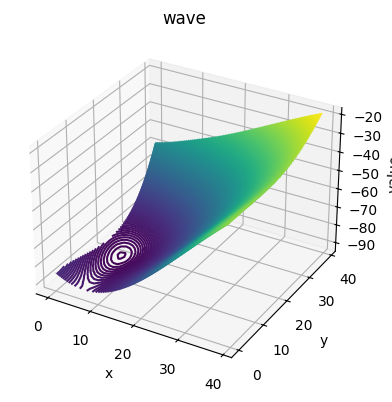

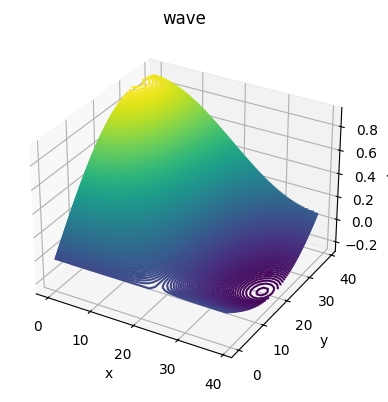

In [27]:
plot_sch(models_infr([0]).reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

(9, 2, 4, 6) (1, 2, 4, 1) [2] [2]


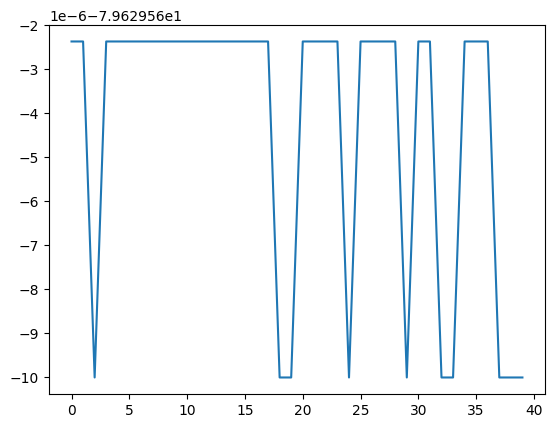

(9, 2, 4, 6) (1, 2, 4, 2) [2] [2]


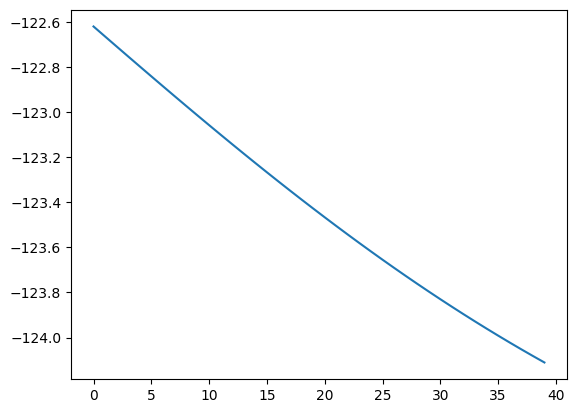

(9, 2, 4, 6) (1, 2, 4, 3) [2] [2]


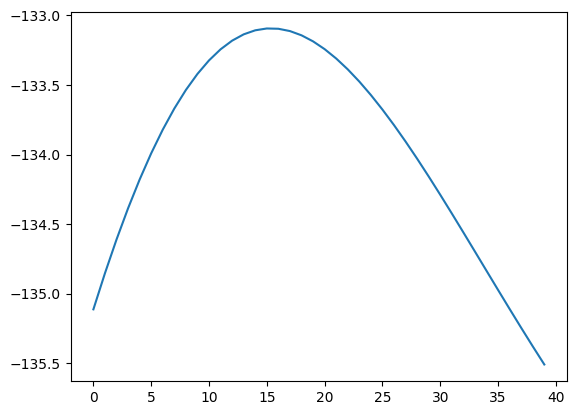

(9, 2, 4, 6) (1, 2, 4, 4) [2] [2]


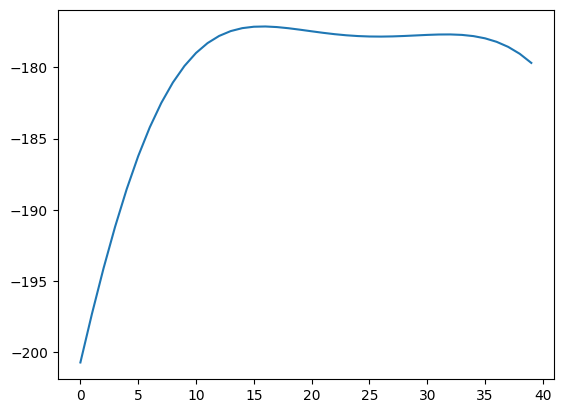

(9, 2, 4, 6) (1, 2, 4, 5) [2] [2]


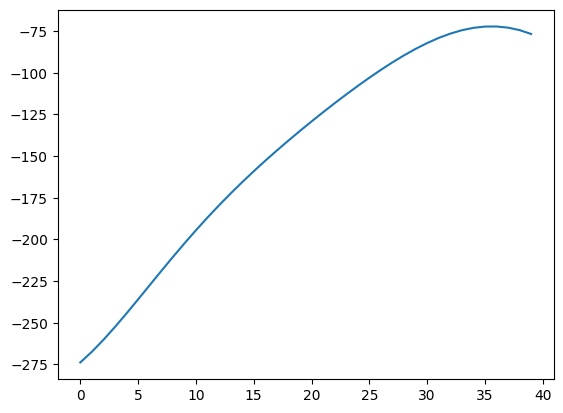

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]


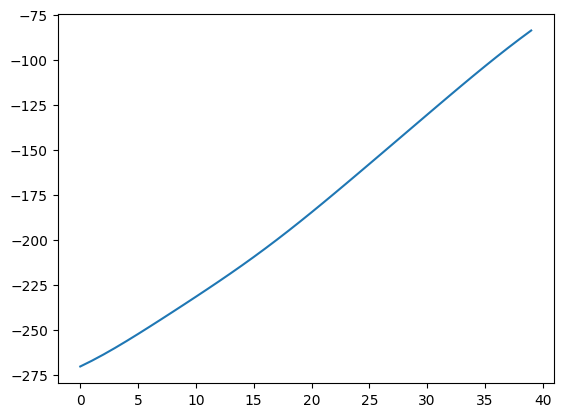

In [129]:
for i in range(6):
    m = models_infr([0], degrees=(0, i+1)).reshape(200, 200, 1)[40, :40, :] * 5

    plt.plot(m)
    plt.show()

(9, 2, 4, 6) (1, 2, 4, 3) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216]
   [ 0.02293275  0.16836119  0.31022173]
   [ 0.04919959 -0.09103608 -0.30091816]
   [ 0.01719464  0.17916398  0.13664919]]

  [[-0.20932725 -0.05121543  0.17945825]
   [-0.02539442  0.02646047 -0.0542903 ]
   [ 0.21853288  0.01045209 -0.00503394]
   [-0.05313112  0.08186758 -0.07705869]]]] d [[[[-0.8505256   1.6566033   0.40806547]]

  [[-0.7837597   0.72082114  0.9227103 ]]

  [[-0.73374605 -2.8984292  -0.3346484 ]]

  [[-0.8171512   0.7060524   1.2874671 ]]]]
      4         3         2
1804 x + 236.4 x - 409.8 x + 55.64 x - 135.1


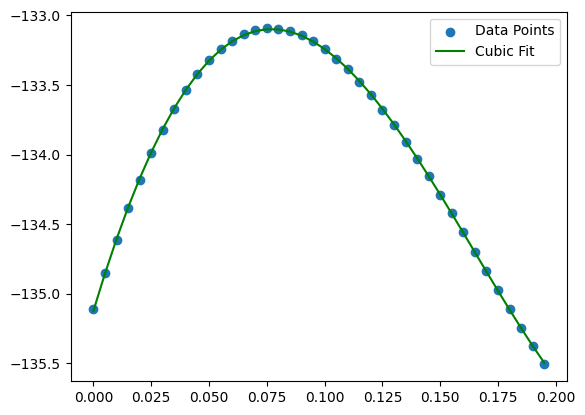

In [72]:
x_sam = np.arange(0, 40)/200
deg = 4

m = models_infr([0], degrees=(0, 3)).reshape(200, 200, 1)[40, :40, :] * 5
coeffs = np.polyfit(x_sam, m, deg=4)

# Create polynomial function
p = np.poly1d(coeffs[:, 0])
print(p)

# Plot data and fit
xp = x_sam
plt.scatter(xp, m, label='Data Points')
plt.plot(xp, p(xp), label='Cubic Fit', color='green')
plt.legend()
plt.show()


In [78]:
c3, c9, c15, c21 = -0.29860216, 0.31022173, -0.30091816, 0.13664919
cs = np.array([c3, c9, c15, c21])

d3, d6, d9, d12 = 0.40806547, 0.9227103, -0.3346484, 1.2874671
ds = np.array([d3, d6, d9, d12])

64*(ds @ cs**2)

7.610987270988145